In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [27]:
import sys
from PIL import Image

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from glob import glob
import numpy as np
import torch
from random import shuffle
import random
from numpy import random as npr
import pandas as pd
import imageio
from PIL import Image


class MethaneLoader(DataLoader):

    def __init__(self, device, mode, plume_id, red=False, alli=False, channels=12):
        self.device = device
        self.mode = mode
        self.reduce = red
        self.channels = channels

        if mode == "train":
            persist = False
        else:
            persist = True
        
        if plume_id is not None:
            self.pos_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/*/{}.npy".format(mode, plume_id)))
#             self.neg_labels = sorted(
#                 glob("/kaggle/input/ch4net-dataset/data/{}/label/pos/{}.npy".format(mode, plume_id)))
            self.neg_labels = []
        else:
            self.pos_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/pos/*.npy".format(mode)))
            self.neg_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/neg/*.npy".format(mode)))

        self.labels = self.pos_labels+self.neg_labels  # None
        
        if not alli:
            self.sample_labels_and_combine(persist=persist)

    def sample_labels_and_combine(self, persist=False):
        """
        Sample a subset of negative labels for each epoch
        """
        # if self.mode == "test":
        if self.mode in ["val"]:
            self.labels = self.pos_labels+self.neg_labels
        else:
            if persist:
                random.seed(555)

            shuffle(self.neg_labels)
            self.labels = self.pos_labels + \
                self.neg_labels[:len(self.pos_labels)]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):

        f = self.labels[index]
        # print(f)

        plume_id = int(f.split("/")[-1].split(".")[0])
        # print(plume_id)

        target = np.load(f)
        context = np.load(
            "/kaggle/input/ch4net-dataset/data/{}/s2/{}.npy".format(self.mode, plume_id))

        if self.channels == 2:
            context = context[..., 10:]
        if self.channels == 5:
            context = np.concatenate(
                [context[..., 1:4], context[..., 10:]], axis=-1)
        
        if self.mode == "train":
            # rotate by 90, 180, 270 degrees
            degrees = npr.choice([0, 90, 180, 270])
            context = np.rot90(context, k=degrees//90)
            target = np.rot90(target, k=degrees//90)
            if npr.rand() > 0.5:
                context = np.flip(context, axis=0)
                target = np.flip(target, axis=0)
            if npr.rand() > 0.5:
                context = np.flip(context, axis=1)
                target = np.flip(target, axis=1)

        # Crop to centre
        # x_c = target.shape[0]//2
        # y_c = target.shape[1]//2
        s = 64

        if self.mode == "train":
            rng = npr.RandomState()
            mid_loc_x = rng.randint(s, target.shape[0]-s)
            mid_loc_y = rng.randint(s, target.shape[1]-s)

        else:
            mid_loc_x = target.shape[0]//2
            mid_loc_y = target.shape[1]//2

        target = target[mid_loc_x-s:mid_loc_x+s,
                        mid_loc_y-s: mid_loc_y+s]

        context = context[mid_loc_x-s:mid_loc_x+s,
                          mid_loc_y-s: mid_loc_y+s, :]

        ### These are not defined before and not necessary for training. 
        ### But these are used in evaluation outputs
#         diff_img = np.array(diff_img[mid_loc_x-s:mid_loc_x+s,
#                                      mid_loc_y-s:mid_loc_y+s, :])
#         diff_img_g = np.array(diff_img_g[mid_loc_x-s:mid_loc_x+s,
#                                          mid_loc_y-s:mid_loc_y+s])
#         rgb_img = np.array(rgb_img[mid_loc_x-s:mid_loc_x+s,
#                                    mid_loc_y-s:mid_loc_y+s, :])

        if self.reduce:
            target = np.array([np.int(target.any())])

        # if self.mode == "test":
            # print("Plume ID: {}, date: {}".format(plume_id, date))

        d = {"pred": torch.from_numpy(context.copy()).float().to(self.device).permute(2, 0, 1)/255,
             "target": torch.from_numpy(target.copy()).float().to(self.device)}
        
        # Print the size of the image tensor
#         print("Image tensor size (context):", d["pred"].size())
#         print("Image tensor size (target):", d["target"].size())

        return d

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    """
    Base MLP module with ReLU activation
    Parameters:
    -----------
    in_channels: Int
        Number of input channels
    out_channels: Int
        Number of output channels
    h_channels: Int
        Number of hidden channels
    h_layers: Int
        Number of hidden layers
    """

    def __init__(self, 
                in_channels, 
                out_channels, 
                h_channels=64,
                h_layers=4):

        super().__init__()

        def hidden_block(h_channels):
            h = nn.Sequential(
            nn.Linear(h_channels, h_channels),
            nn.ReLU())
            return h

        # Model
        
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, h_channels),
            nn.ReLU(),
            *[hidden_block(h_channels) for _ in range(h_layers)],
            nn.Linear(h_channels, out_channels) 
        )

    def forward(self, x):
        return self.mlp(x)

class Unet(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 div_factor=8,
                 prob_output=True,
                 class_output=False

    ):
        super(Unet, self).__init__()

        self.n_channels = in_channels
        self.bilinear = True
        self.sigmoid = nn.Sigmoid()
        self.prob_output = prob_output
        self.class_output = class_output

        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

        def down(in_channels, out_channels):
            return nn.Sequential(
                nn.MaxPool2d(2),
                double_conv(in_channels, out_channels)
            )

        class up(nn.Module):
            def __init__(self, in_channels, out_channels, bilinear=True):
                super().__init__()

                if bilinear:
                    self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
                else:
                    self.up = nn.ConvTranpose2d(in_channels // 2, in_channels // 2,
                                                kernel_size=2, stride=2)

                self.conv = double_conv(in_channels, out_channels)

            def forward(self, x1, x2):
                x1 = self.up(x1)
                # [?, C, H, W]
                diffY = x2.size()[2] - x1.size()[2]
                diffX = x2.size()[3] - x1.size()[3]

                x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                                diffY // 2, diffY - diffY // 2])
                x = torch.cat([x2, x1], dim=1) ## why 1?
                return self.conv(x)

        self.inc = double_conv(self.n_channels, 64//div_factor)
        self.down1 = down(64//div_factor, 128//div_factor)
        self.down2 = down(128//div_factor, 256//div_factor)
        self.down3 = down(256//div_factor, 512//div_factor)
        self.down4 = down(512//div_factor, 512//div_factor)
        self.up1 = up(1024//div_factor, 256//div_factor)
        self.up2 = up(512//div_factor, 128//div_factor)
        self.up3 = up(256//div_factor, 64//div_factor)
        self.up4 = up(128//div_factor, 128//div_factor)
        self.out = nn.Conv2d(128//div_factor, 1, kernel_size=1)


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        #return self.out(x).permute(0,2,3,1)

        if self.prob_output:
            x = self.out(x)
            return self.sigmoid(x).permute(0,2,3,1)
        else:
            return self.out(x).permute(0,2,3,1)

In [29]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

class Attention_block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

class UNet_Attention(nn.Module):
    def __init__(self, img_ch=12, output_ch=1):
        super(UNet_Attention, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)

        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

        return out

# Example usage:

# Instantiate the model
model = UNet_Attention(img_ch=12, output_ch=1)

# Example input tensor with shape [batch_size, channels, height, width]
input_tensor = torch.randn(16, 12, 128, 128)  # Example batch size of 16

# Example target tensor with shape [batch_size, height, width]
target_tensor = torch.randn(16, 128, 128)

# Adjust the target tensor to match the output shape
target_tensor = target_tensor.unsqueeze(1)

# Forward pass
output = model(input_tensor)

# Check output shape
print(f"Output shape: {output.shape}")  # Should be [16, 1, 128, 128]
print(f"Target shape: {target_tensor.shape}")  # Should be [16, 1, 128, 128]


Output shape: torch.Size([16, 1, 128, 128])
Target shape: torch.Size([16, 1, 128, 128])


In [30]:
from matplotlib import pyplot as plt
import torch
import scipy
import numpy as np
from tqdm import tqdm
from torch import autograd
from torch.utils.data import DataLoader
# from loader import *


class Trainer():
    """
    Training class for the neural process models
    """

    def __init__(self,
                 model,
                 train_loader,
                 val_loader,
                 train_dataset,
                 loss_function,
                 save_path,
                 learning_rate):

        # Model and data
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.train_dataset = train_dataset
        self.save_path = save_path

        # Training parameters
        self.opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.loss_function = loss_function
        self.sched = torch.optim.lr_scheduler.ReduceLROnPlateau(self.opt, mode='min', factor=0.5, patience=9)

        # Losses
        self.losses = []

    def plot_losses(self):
        """
        Plot losses for the trained model
        """
        plt.plot(np.array(self.losses))
        plt.xlabel("epoch")
        plt.ylabel("NLL")
        plt.show()

    def _unravel_to_numpy(self, x):
        return x.view(-1).detach().cpu().numpy()

    def eval_epoch(self, verbose=False):

        self.model.eval()
        lf = []

        outs = []
        ts = []

        with torch.no_grad():
            for task in self.val_loader:

                out = self.model(task["pred"])
                lf.append(self.loss_function(np.squeeze(out), task["target"]))
                outs.append(out.detach().cpu().numpy())
                ts.append(task["target"].detach().cpu().numpy())

        # Get loss function
        log_loss = torch.mean(torch.tensor(lf))
        print("- Log loss: {}".format(log_loss))
    
        if verbose:
            return log_loss, np.concatenate(outs, axis=0), np.concatenate(ts, axis=0)

        return log_loss

    def train(self, n_epochs=100):

        # Init progress bar
        best_loss = 100000
        best_model_state_dict = None
        best_opt_state_dict = None
        i = 1

        for epoch in range(n_epochs):

            autograd.set_detect_anomaly(True)

            print("Training epoch {}".format(epoch))

            if epoch < 500:
                self.model.train()
                self.train_dataset.sample_labels_and_combine()
                self.train_loader = DataLoader(self.train_dataset,
                                               batch_size=16,
                                               shuffle=True)

            with tqdm(self.train_loader, unit="batch") as tepoch:
                for task in tepoch:
                    
                    out = self.model(task["pred"])
                    
                    # print("loss")
                    loss = self.loss_function(np.squeeze(out), task["target"])

                    loss.backward()
                    self.opt.step()
                    self.opt.zero_grad()
                    # print("out")
                    tepoch.set_postfix(loss=loss.item())
                epoch_loss = self.eval_epoch(verbose=False)
                self.sched.step(epoch_loss)
                print(self.sched.get_last_lr())
            
            if np.logical_or(epoch_loss <= best_loss, epoch >= 1000):
#                 torch.save({
#                     'epoch': epoch,
#                     'model_state_dict': self.model.state_dict(),
#                     'optimizer_state_dict': self.opt.state_dict(),
#                     'loss': epoch_loss
#                 }, self.save_path+"epoch_{}".format(epoch))
                best_model_state_dict = self.model.state_dict()
                best_opt_state_dict = self.opt.state_dict()
                best_loss = epoch_loss
#                 np.save("outs.npy", o)
#                 np.save("ts.npy", t)

            self.losses.append(epoch_loss)
    
            ## checkpoint
            if i % 20 == 0 or i == n_epochs: 
                np.save(self.save_path+"losses.npy", np.array(self.losses))
                self.plot_losses()

                torch.save({
                    # 'epoch': epoch,
                    'model_state_dict': best_model_state_dict,
                    'optimizer_state_dict': best_opt_state_dict,
                    'loss': best_loss
                }, self.save_path+"final_model".format(epoch))
            i += 1

        print("Training complete!")

In [31]:
!mkdir -p /kaggle/working/train_out
!mkdir -p /kaggle/working/eval_out

In [32]:
import torch
import torch.nn as nn
from torchvision.ops import sigmoid_focal_loss

def loss(pred, target):
#     print(pred.shape, target.shape)
    bce_loss = nn.BCEWithLogitsLoss(reduction="none") 
    ll = bce_loss(pred, target)

    ll = ll.sum(dim=(-2,-1)) #*mask
    return ll.mean()


class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce_loss = nn.BCEWithLogitsLoss(reduction="none")
    
    def forward(self, pred, target):
        loss = self.bce_loss(pred, target)
        prob = torch.sigmoid(pred)  # Predicted probability
        alpha = torch.where(target == 1, self.alpha, 1 - self.alpha)  # Class balancing factor
        focal_weight = torch.where(target == 1, 1 - prob, prob)  # Focusing weight
        focal_weight = alpha * focal_weight**self.gamma  # Apply alpha and gamma
        focal_loss = focal_weight * loss
        
        focal_loss = focal_loss.sum(dim=(-2,-1)) #*mask
        return focal_loss.mean()


pred = torch.randn(16, 128, 128).float()
target = torch.randint(0, 2, (16, 128, 128)).float()

def weighted_bce_loss(pred, target):
    target = target.float()

    # Calculate positive weight as the ratio of negative to positive samples for each batch
    neg_count = (target == 0).sum(dim=(-2, -1)).float()
    pos_count = (target == 1).sum(dim=(-2, -1)).float()
    
    weights = torch.where(pos_count > 0, neg_count / pos_count, torch.tensor(1.0, device=pred.device))

    pos_weight = torch.zeros_like(target)
    for i in range(1):
        pos_weight[i] = torch.where(target[i] == 1, weights[i], torch.tensor(1.0, device=pred.device))
        pos_weight[i] += 1 - target[i]
        
    if(target.dim() == 3):
        target = target.unsqueeze(1)
        pred = pred.unsqueeze(1)
        pos_weight = pos_weight.unsqueeze(1)
    elif (target.dim() == 2):
        target = target.unsqueeze(0).unsqueeze(0)
        pred = pred.unsqueeze(0).unsqueeze(0)
        pos_weight = pos_weight.unsqueeze(0).unsqueeze(0)
#     print(target.shape, pred.shape, pos_weight.shape)
    
    bce_loss = nn.BCEWithLogitsLoss(reduction="none", pos_weight=pos_weight)
    ll = bce_loss(pred, target)

    # The loss values are summed across the last two dimensions of the tensor. 
    # If the tensor is 4D (e.g., batch x channels x height x width), this sums over the height and width dimensions, leaving a per-batch, per-channel loss.
    ll = ll.sum(dim=(-2,-1))
    
    return ll.mean()

focal_loss = FocalLoss(alpha=0.75, gamma=2.0)
focal_loss(pred, target)

tensor(2836.1860)

Training epoch 0


100%|██████████| 75/75 [00:18<00:00,  3.99batch/s, loss=372]   


- Log loss: 376.6937255859375
[0.0001]
Training epoch 1


100%|██████████| 75/75 [00:18<00:00,  4.04batch/s, loss=317]


- Log loss: 312.0745849609375
[0.0001]
Training epoch 2


100%|██████████| 75/75 [00:18<00:00,  4.06batch/s, loss=258]


- Log loss: 280.3996887207031
[0.0001]
Training epoch 3


100%|██████████| 75/75 [00:18<00:00,  4.06batch/s, loss=216]


- Log loss: 285.5828857421875
[0.0001]
Training epoch 4


100%|██████████| 75/75 [00:18<00:00,  4.03batch/s, loss=210]


- Log loss: 259.64642333984375
[0.0001]
Training epoch 5


100%|██████████| 75/75 [00:18<00:00,  4.06batch/s, loss=206]


- Log loss: 267.0200500488281
[0.0001]
Training epoch 6


100%|██████████| 75/75 [00:18<00:00,  4.04batch/s, loss=307]


- Log loss: 223.5506134033203
[0.0001]
Training epoch 7


100%|██████████| 75/75 [00:18<00:00,  4.04batch/s, loss=256]


- Log loss: 218.9505157470703
[0.0001]
Training epoch 8


100%|██████████| 75/75 [00:18<00:00,  4.05batch/s, loss=233]


- Log loss: 221.1352081298828
[0.0001]
Training epoch 9


100%|██████████| 75/75 [00:18<00:00,  4.05batch/s, loss=198]


- Log loss: 205.53392028808594
[0.0001]
Training epoch 10


100%|██████████| 75/75 [00:18<00:00,  4.03batch/s, loss=204]


- Log loss: 205.66517639160156
[0.0001]
Training epoch 11


100%|██████████| 75/75 [00:18<00:00,  4.03batch/s, loss=184]


- Log loss: 240.3642578125
[0.0001]
Training epoch 12


100%|██████████| 75/75 [00:18<00:00,  3.99batch/s, loss=179]


- Log loss: 200.7646026611328
[0.0001]
Training epoch 13


100%|██████████| 75/75 [00:18<00:00,  4.05batch/s, loss=131]


- Log loss: 205.0496063232422
[0.0001]
Training epoch 14


100%|██████████| 75/75 [00:18<00:00,  4.08batch/s, loss=161]


- Log loss: 197.25265502929688
[0.0001]
Training epoch 15


100%|██████████| 75/75 [00:18<00:00,  3.99batch/s, loss=134]


- Log loss: 186.96363830566406
[0.0001]
Training epoch 16


100%|██████████| 75/75 [00:18<00:00,  4.04batch/s, loss=254]


- Log loss: 187.88319396972656
[0.0001]
Training epoch 17


100%|██████████| 75/75 [00:18<00:00,  4.05batch/s, loss=150] 


- Log loss: 187.9349822998047
[0.0001]
Training epoch 18


100%|██████████| 75/75 [00:18<00:00,  4.02batch/s, loss=124]


- Log loss: 228.34910583496094
[0.0001]
Training epoch 19


100%|██████████| 75/75 [00:18<00:00,  4.07batch/s, loss=161] 


- Log loss: 181.14370727539062
[0.0001]


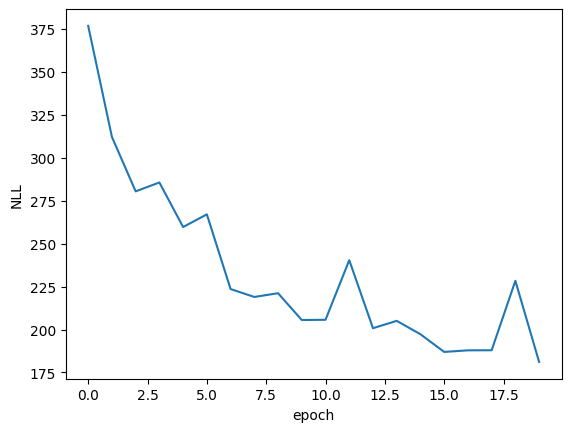

Training epoch 20


100%|██████████| 75/75 [00:18<00:00,  4.00batch/s, loss=185]


- Log loss: 171.3739013671875
[0.0001]
Training epoch 21


100%|██████████| 75/75 [00:18<00:00,  4.07batch/s, loss=160] 


- Log loss: 186.42697143554688
[0.0001]
Training epoch 22


100%|██████████| 75/75 [00:18<00:00,  4.06batch/s, loss=166] 


- Log loss: 163.6321563720703
[0.0001]
Training epoch 23


100%|██████████| 75/75 [00:18<00:00,  3.98batch/s, loss=119]


- Log loss: 173.91366577148438
[0.0001]
Training epoch 24


100%|██████████| 75/75 [00:18<00:00,  4.09batch/s, loss=167] 


- Log loss: 161.70602416992188
[0.0001]
Training epoch 25


100%|██████████| 75/75 [00:18<00:00,  4.05batch/s, loss=141] 


- Log loss: 159.32461547851562
[0.0001]
Training epoch 26


100%|██████████| 75/75 [00:18<00:00,  4.01batch/s, loss=156] 


- Log loss: 169.99374389648438
[0.0001]
Training epoch 27


100%|██████████| 75/75 [00:18<00:00,  4.08batch/s, loss=229] 


- Log loss: 159.39613342285156
[0.0001]
Training epoch 28


100%|██████████| 75/75 [00:18<00:00,  4.04batch/s, loss=113] 


- Log loss: 153.0890655517578
[0.0001]
Training epoch 29


100%|██████████| 75/75 [00:18<00:00,  4.00batch/s, loss=98.7]


- Log loss: 147.08692932128906
[0.0001]
Training epoch 30


100%|██████████| 75/75 [00:18<00:00,  4.07batch/s, loss=164] 


- Log loss: 147.3434600830078
[0.0001]
Training epoch 31


100%|██████████| 75/75 [00:18<00:00,  4.04batch/s, loss=118] 


- Log loss: 139.3177490234375
[0.0001]
Training epoch 32


100%|██████████| 75/75 [00:18<00:00,  4.05batch/s, loss=74.8]


- Log loss: 149.77560424804688
[0.0001]
Training epoch 33


100%|██████████| 75/75 [00:18<00:00,  4.07batch/s, loss=154] 


- Log loss: 141.9811248779297
[0.0001]
Training epoch 34


100%|██████████| 75/75 [00:18<00:00,  4.02batch/s, loss=118] 


- Log loss: 153.0653076171875
[0.0001]
Training epoch 35


100%|██████████| 75/75 [00:18<00:00,  4.05batch/s, loss=130] 


- Log loss: 143.08712768554688
[0.0001]
Training epoch 36


100%|██████████| 75/75 [00:18<00:00,  4.00batch/s, loss=114] 


- Log loss: 147.15908813476562
[0.0001]
Training epoch 37


100%|██████████| 75/75 [00:18<00:00,  3.97batch/s, loss=163] 


- Log loss: 135.25440979003906
[0.0001]
Training epoch 38


100%|██████████| 75/75 [00:18<00:00,  4.03batch/s, loss=217] 


- Log loss: 150.3150634765625
[0.0001]
Training epoch 39


100%|██████████| 75/75 [00:18<00:00,  3.99batch/s, loss=133] 


- Log loss: 159.6946563720703
[0.0001]


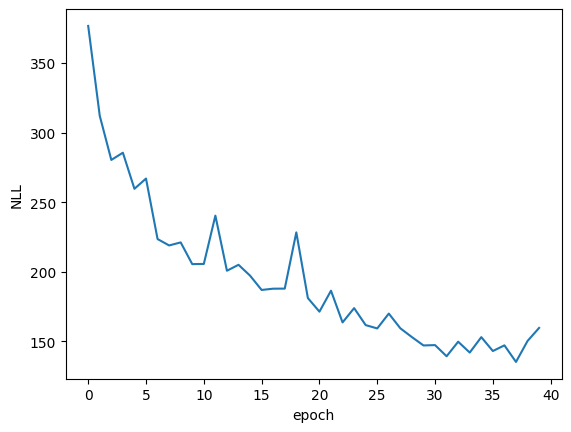

Training epoch 40


100%|██████████| 75/75 [00:18<00:00,  4.03batch/s, loss=133] 


- Log loss: 138.8130340576172
[0.0001]
Training epoch 41


100%|██████████| 75/75 [00:18<00:00,  4.04batch/s, loss=149] 


- Log loss: 135.95928955078125
[0.0001]
Training epoch 42


100%|██████████| 75/75 [00:18<00:00,  3.97batch/s, loss=117] 


- Log loss: 141.45811462402344
[0.0001]
Training epoch 43


100%|██████████| 75/75 [00:18<00:00,  4.02batch/s, loss=111] 


- Log loss: 139.67298889160156
[0.0001]
Training epoch 44


100%|██████████| 75/75 [00:18<00:00,  4.06batch/s, loss=141] 


- Log loss: 153.59170532226562
[0.0001]
Training epoch 45


100%|██████████| 75/75 [00:18<00:00,  4.00batch/s, loss=119] 


- Log loss: 141.20050048828125
[0.0001]
Training epoch 46


100%|██████████| 75/75 [00:18<00:00,  4.07batch/s, loss=117] 


- Log loss: 134.51898193359375
[0.0001]
Training epoch 47


100%|██████████| 75/75 [00:18<00:00,  4.05batch/s, loss=225] 


- Log loss: 148.8270263671875
[0.0001]
Training epoch 48


100%|██████████| 75/75 [00:18<00:00,  4.02batch/s, loss=105] 


- Log loss: 199.69374084472656
[0.0001]
Training epoch 49


100%|██████████| 75/75 [00:18<00:00,  4.03batch/s, loss=80.9]


- Log loss: 151.93023681640625
[0.0001]
Training epoch 50


100%|██████████| 75/75 [00:18<00:00,  4.03batch/s, loss=115] 


- Log loss: 141.71603393554688
[0.0001]
Training epoch 51


100%|██████████| 75/75 [00:18<00:00,  4.08batch/s, loss=80.3]


- Log loss: 334.7513427734375
[0.0001]
Training epoch 52


100%|██████████| 75/75 [00:18<00:00,  4.04batch/s, loss=127] 


- Log loss: 150.66998291015625
[0.0001]
Training epoch 53


100%|██████████| 75/75 [00:18<00:00,  3.95batch/s, loss=111] 


- Log loss: 140.3918914794922
[0.0001]
Training epoch 54


100%|██████████| 75/75 [00:18<00:00,  4.03batch/s, loss=95.9]


- Log loss: 133.45254516601562
[0.0001]
Training epoch 55


100%|██████████| 75/75 [00:18<00:00,  3.98batch/s, loss=66.7]


- Log loss: 128.52317810058594
[0.0001]
Training epoch 56


100%|██████████| 75/75 [00:18<00:00,  3.97batch/s, loss=93.9]


- Log loss: 135.108154296875
[0.0001]
Training epoch 57


100%|██████████| 75/75 [00:18<00:00,  3.97batch/s, loss=75.4]


- Log loss: 151.28013610839844
[0.0001]
Training epoch 58


100%|██████████| 75/75 [00:18<00:00,  3.95batch/s, loss=100] 


- Log loss: 152.46978759765625
[0.0001]
Training epoch 59


100%|██████████| 75/75 [00:19<00:00,  3.94batch/s, loss=122] 


- Log loss: 127.94684600830078
[0.0001]


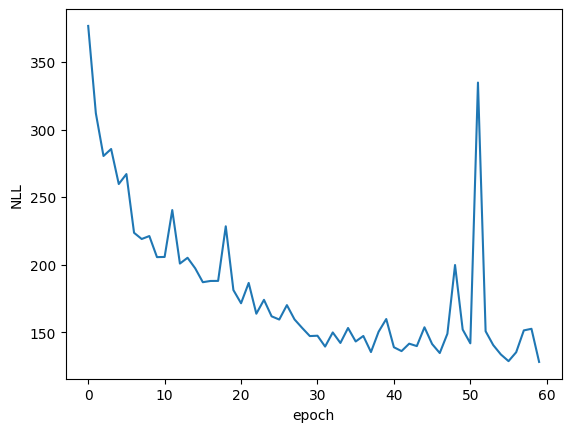

Training epoch 60


100%|██████████| 75/75 [00:18<00:00,  4.02batch/s, loss=156] 


- Log loss: 135.0127716064453
[0.0001]
Training epoch 61


100%|██████████| 75/75 [00:19<00:00,  3.92batch/s, loss=96.3]


- Log loss: 134.0665740966797
[0.0001]
Training epoch 62


100%|██████████| 75/75 [00:18<00:00,  3.99batch/s, loss=130] 


- Log loss: 125.71683502197266
[0.0001]
Training epoch 63


100%|██████████| 75/75 [00:18<00:00,  4.02batch/s, loss=54.1]


- Log loss: 145.8060760498047
[0.0001]
Training epoch 64


100%|██████████| 75/75 [00:18<00:00,  3.99batch/s, loss=59.3]


- Log loss: 125.38229370117188
[0.0001]
Training epoch 65


100%|██████████| 75/75 [00:18<00:00,  4.01batch/s, loss=85.7]


- Log loss: 138.58876037597656
[0.0001]
Training epoch 66


100%|██████████| 75/75 [00:18<00:00,  4.00batch/s, loss=112] 


- Log loss: 150.03114318847656
[0.0001]
Training epoch 67


100%|██████████| 75/75 [00:18<00:00,  3.99batch/s, loss=136] 


- Log loss: 124.107421875
[0.0001]
Training epoch 68


100%|██████████| 75/75 [00:18<00:00,  4.03batch/s, loss=86.4]


- Log loss: 127.74383544921875
[0.0001]
Training epoch 69


100%|██████████| 75/75 [00:18<00:00,  3.97batch/s, loss=166] 


- Log loss: 137.9584197998047
[0.0001]
Training epoch 70


100%|██████████| 75/75 [00:18<00:00,  4.00batch/s, loss=123] 


- Log loss: 121.98762512207031
[0.0001]
Training epoch 71


100%|██████████| 75/75 [00:18<00:00,  4.05batch/s, loss=134] 


- Log loss: 140.38523864746094
[0.0001]
Training epoch 72


100%|██████████| 75/75 [00:19<00:00,  3.92batch/s, loss=55.6]


- Log loss: 121.50798034667969
[0.0001]
Training epoch 73


100%|██████████| 75/75 [00:18<00:00,  4.01batch/s, loss=109] 


- Log loss: 126.6853256225586
[0.0001]
Training epoch 74


100%|██████████| 75/75 [00:18<00:00,  4.05batch/s, loss=108] 


- Log loss: 131.3296661376953
[0.0001]
Training epoch 75


100%|██████████| 75/75 [00:18<00:00,  3.97batch/s, loss=173] 


- Log loss: 124.5064697265625
[0.0001]
Training epoch 76


100%|██████████| 75/75 [00:18<00:00,  4.02batch/s, loss=56.2]


- Log loss: 125.70708465576172
[0.0001]
Training epoch 77


100%|██████████| 75/75 [00:18<00:00,  4.04batch/s, loss=78.3]


- Log loss: 122.49998474121094
[0.0001]
Training epoch 78


100%|██████████| 75/75 [00:18<00:00,  4.03batch/s, loss=128] 


- Log loss: 145.33006286621094
[0.0001]
Training epoch 79


100%|██████████| 75/75 [00:18<00:00,  4.04batch/s, loss=77.3]


- Log loss: 126.84344482421875
[0.0001]


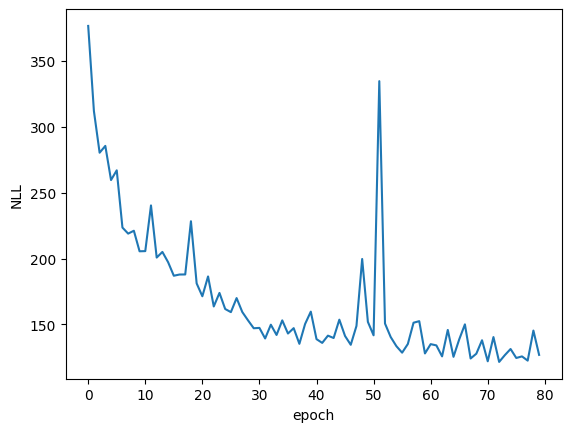

Training epoch 80


100%|██████████| 75/75 [00:18<00:00,  3.99batch/s, loss=142] 


- Log loss: 120.21009826660156
[0.0001]
Training epoch 81


100%|██████████| 75/75 [00:18<00:00,  4.04batch/s, loss=59.6]


- Log loss: 137.5044708251953
[0.0001]
Training epoch 82


100%|██████████| 75/75 [00:18<00:00,  4.04batch/s, loss=80.9]


- Log loss: 131.81576538085938
[0.0001]
Training epoch 83


100%|██████████| 75/75 [00:18<00:00,  3.98batch/s, loss=175] 


- Log loss: 120.65757751464844
[0.0001]
Training epoch 84


100%|██████████| 75/75 [00:18<00:00,  4.08batch/s, loss=112] 


- Log loss: 131.1604766845703
[0.0001]
Training epoch 85


100%|██████████| 75/75 [00:18<00:00,  4.03batch/s, loss=97.2]


- Log loss: 131.149169921875
[0.0001]
Training epoch 86


100%|██████████| 75/75 [00:18<00:00,  3.99batch/s, loss=122] 


- Log loss: 195.66757202148438
[0.0001]
Training epoch 87


100%|██████████| 75/75 [00:18<00:00,  4.07batch/s, loss=85]  


- Log loss: 121.36841583251953
[0.0001]
Training epoch 88


100%|██████████| 75/75 [00:18<00:00,  4.02batch/s, loss=181] 


- Log loss: 111.71361541748047
[0.0001]
Training epoch 89


100%|██████████| 75/75 [00:18<00:00,  4.02batch/s, loss=64.9]


- Log loss: 125.70114135742188
[0.0001]
Training epoch 90


100%|██████████| 75/75 [00:18<00:00,  4.03batch/s, loss=56.6]


- Log loss: 128.78997802734375
[0.0001]
Training epoch 91


100%|██████████| 75/75 [00:18<00:00,  3.98batch/s, loss=166] 


- Log loss: 138.56729125976562
[0.0001]
Training epoch 92


100%|██████████| 75/75 [00:18<00:00,  4.03batch/s, loss=86]  


- Log loss: 128.8330078125
[0.0001]
Training epoch 93


100%|██████████| 75/75 [00:18<00:00,  4.03batch/s, loss=64.7]


- Log loss: 170.3093719482422
[0.0001]
Training epoch 94


100%|██████████| 75/75 [00:18<00:00,  4.04batch/s, loss=96.3]


- Log loss: 139.32374572753906
[0.0001]
Training epoch 95


100%|██████████| 75/75 [00:18<00:00,  4.05batch/s, loss=43.4]


- Log loss: 117.99718475341797
[0.0001]
Training epoch 96


100%|██████████| 75/75 [00:18<00:00,  4.05batch/s, loss=124] 


- Log loss: 119.3509750366211
[0.0001]
Training epoch 97


100%|██████████| 75/75 [00:18<00:00,  4.05batch/s, loss=116] 


- Log loss: 116.80521392822266
[0.0001]
Training epoch 98


100%|██████████| 75/75 [00:18<00:00,  4.07batch/s, loss=93.5]


- Log loss: 122.6365966796875
[5e-05]
Training epoch 99


100%|██████████| 75/75 [00:18<00:00,  4.01batch/s, loss=60.1]


- Log loss: 109.38338470458984
[5e-05]


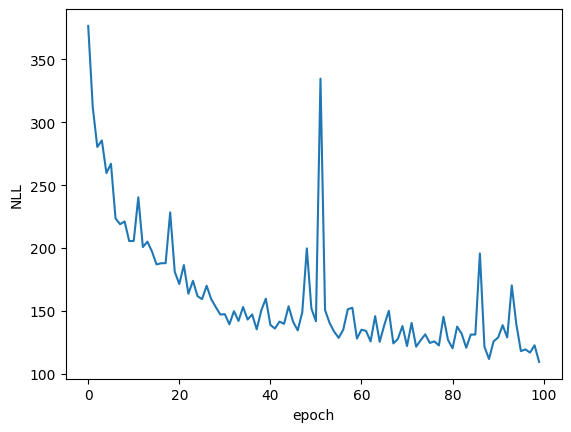

Training epoch 100


100%|██████████| 75/75 [00:18<00:00,  4.03batch/s, loss=111] 


- Log loss: 119.13397216796875
[5e-05]
Training epoch 101


100%|██████████| 75/75 [00:18<00:00,  4.03batch/s, loss=53.4]


- Log loss: 101.99775695800781
[5e-05]
Training epoch 102


100%|██████████| 75/75 [00:18<00:00,  3.98batch/s, loss=64.5]


- Log loss: 109.92628479003906
[5e-05]
Training epoch 103


100%|██████████| 75/75 [00:18<00:00,  4.01batch/s, loss=67]  


- Log loss: 110.54801940917969
[5e-05]
Training epoch 104


100%|██████████| 75/75 [00:18<00:00,  4.00batch/s, loss=80]  


- Log loss: 119.59940338134766
[5e-05]
Training epoch 105


100%|██████████| 75/75 [00:18<00:00,  3.96batch/s, loss=90.1]


- Log loss: 107.5340576171875
[5e-05]
Training epoch 106


100%|██████████| 75/75 [00:18<00:00,  4.05batch/s, loss=51.6]


- Log loss: 115.99585723876953
[5e-05]
Training epoch 107


100%|██████████| 75/75 [00:18<00:00,  4.03batch/s, loss=49.4]


- Log loss: 106.70536804199219
[5e-05]
Training epoch 108


100%|██████████| 75/75 [00:18<00:00,  4.00batch/s, loss=54.5]


- Log loss: 111.05593872070312
[5e-05]
Training epoch 109


100%|██████████| 75/75 [00:18<00:00,  4.00batch/s, loss=65.8]


- Log loss: 112.35127258300781
[5e-05]
Training epoch 110


100%|██████████| 75/75 [00:18<00:00,  3.95batch/s, loss=79.3]


- Log loss: 105.16561126708984
[5e-05]
Training epoch 111


100%|██████████| 75/75 [00:18<00:00,  4.03batch/s, loss=125] 


- Log loss: 116.35846710205078
[2.5e-05]
Training epoch 112


100%|██████████| 75/75 [00:18<00:00,  4.01batch/s, loss=51.1]


- Log loss: 100.28580474853516
[2.5e-05]
Training epoch 113


100%|██████████| 75/75 [00:18<00:00,  3.95batch/s, loss=91.5]


- Log loss: 102.7069091796875
[2.5e-05]
Training epoch 114


100%|██████████| 75/75 [00:18<00:00,  4.03batch/s, loss=97.8]


- Log loss: 108.29364013671875
[2.5e-05]
Training epoch 115


100%|██████████| 75/75 [00:18<00:00,  4.01batch/s, loss=29.3]


- Log loss: 101.44046783447266
[2.5e-05]
Training epoch 116


100%|██████████| 75/75 [00:18<00:00,  3.99batch/s, loss=93.3]


- Log loss: 99.55378723144531
[2.5e-05]
Training epoch 117


100%|██████████| 75/75 [00:18<00:00,  4.05batch/s, loss=60.3]


- Log loss: 109.6668701171875
[2.5e-05]
Training epoch 118


100%|██████████| 75/75 [00:18<00:00,  3.99batch/s, loss=50.6]


- Log loss: 101.92803192138672
[2.5e-05]
Training epoch 119


100%|██████████| 75/75 [00:18<00:00,  3.99batch/s, loss=54]  


- Log loss: 104.92813873291016
[2.5e-05]


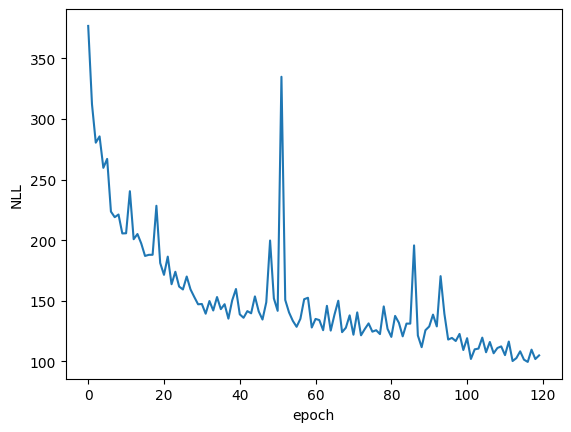

Training epoch 120


100%|██████████| 75/75 [00:18<00:00,  4.02batch/s, loss=44]  


- Log loss: 103.87259674072266
[2.5e-05]
Training epoch 121


100%|██████████| 75/75 [00:18<00:00,  4.00batch/s, loss=66.8]


- Log loss: 101.03484344482422
[2.5e-05]
Training epoch 122


100%|██████████| 75/75 [00:18<00:00,  4.03batch/s, loss=53.9]


- Log loss: 100.99958038330078
[2.5e-05]
Training epoch 123


100%|██████████| 75/75 [00:18<00:00,  3.95batch/s, loss=77.7]


- Log loss: 99.04761505126953
[2.5e-05]
Training epoch 124


100%|██████████| 75/75 [00:18<00:00,  3.97batch/s, loss=30.7]


- Log loss: 98.27552795410156
[2.5e-05]
Training epoch 125


100%|██████████| 75/75 [00:18<00:00,  3.98batch/s, loss=68.4]


- Log loss: 103.9037857055664
[2.5e-05]
Training epoch 126


100%|██████████| 75/75 [00:18<00:00,  3.97batch/s, loss=46.1]


- Log loss: 104.47290802001953
[2.5e-05]
Training epoch 127


100%|██████████| 75/75 [00:18<00:00,  4.02batch/s, loss=42.2]


- Log loss: 105.38601684570312
[2.5e-05]
Training epoch 128


100%|██████████| 75/75 [00:18<00:00,  4.05batch/s, loss=158] 


- Log loss: 106.2999267578125
[2.5e-05]
Training epoch 129


100%|██████████| 75/75 [00:18<00:00,  3.97batch/s, loss=55.3]


- Log loss: 103.03431701660156
[2.5e-05]
Training epoch 130


100%|██████████| 75/75 [00:18<00:00,  4.00batch/s, loss=82.6]


- Log loss: 109.01346588134766
[2.5e-05]
Training epoch 131


100%|██████████| 75/75 [00:18<00:00,  4.02batch/s, loss=58.4]


- Log loss: 110.07711029052734
[2.5e-05]
Training epoch 132


100%|██████████| 75/75 [00:18<00:00,  3.96batch/s, loss=73.2]


- Log loss: 110.32198333740234
[2.5e-05]
Training epoch 133


100%|██████████| 75/75 [00:18<00:00,  3.98batch/s, loss=43.2]


- Log loss: 107.98139190673828
[2.5e-05]
Training epoch 134


100%|██████████| 75/75 [00:18<00:00,  4.02batch/s, loss=41.1]


- Log loss: 102.38863372802734
[1.25e-05]
Training epoch 135


100%|██████████| 75/75 [00:18<00:00,  3.98batch/s, loss=34.5]


- Log loss: 103.8111572265625
[1.25e-05]
Training epoch 136


100%|██████████| 75/75 [00:18<00:00,  4.01batch/s, loss=56.1]


- Log loss: 104.35739135742188
[1.25e-05]
Training epoch 137


100%|██████████| 75/75 [00:18<00:00,  3.99batch/s, loss=55.8]


- Log loss: 101.98067474365234
[1.25e-05]
Training epoch 138


100%|██████████| 75/75 [00:18<00:00,  4.02batch/s, loss=76.7]


- Log loss: 106.49241638183594
[1.25e-05]
Training epoch 139


100%|██████████| 75/75 [00:18<00:00,  4.01batch/s, loss=33.9]


- Log loss: 107.83615112304688
[1.25e-05]


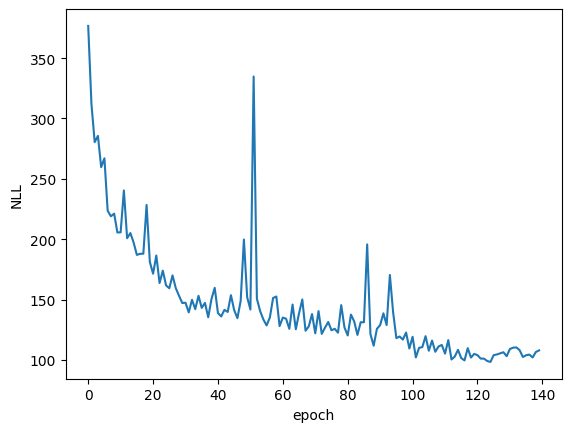

Training epoch 140


100%|██████████| 75/75 [00:19<00:00,  3.94batch/s, loss=48.3]


- Log loss: 104.46538543701172
[1.25e-05]
Training epoch 141


100%|██████████| 75/75 [00:18<00:00,  4.03batch/s, loss=31.3]


- Log loss: 115.26566314697266
[1.25e-05]
Training epoch 142


100%|██████████| 75/75 [00:18<00:00,  4.00batch/s, loss=94.8]


- Log loss: 103.4917984008789
[1.25e-05]
Training epoch 143


100%|██████████| 75/75 [00:18<00:00,  3.98batch/s, loss=44.4]


- Log loss: 107.66213989257812
[1.25e-05]
Training epoch 144


100%|██████████| 75/75 [00:18<00:00,  4.00batch/s, loss=39.9]


- Log loss: 107.92330932617188
[6.25e-06]
Training epoch 145


100%|██████████| 75/75 [00:18<00:00,  3.96batch/s, loss=57.4]


- Log loss: 103.46498107910156
[6.25e-06]
Training epoch 146


100%|██████████| 75/75 [00:18<00:00,  4.00batch/s, loss=47.1]


- Log loss: 106.35765838623047
[6.25e-06]
Training epoch 147


100%|██████████| 75/75 [00:18<00:00,  4.02batch/s, loss=137] 


- Log loss: 103.74130249023438
[6.25e-06]
Training epoch 148


100%|██████████| 75/75 [00:18<00:00,  4.00batch/s, loss=50.3]


- Log loss: 102.83902740478516
[6.25e-06]
Training epoch 149


100%|██████████| 75/75 [00:18<00:00,  4.04batch/s, loss=70.2]


- Log loss: 108.750244140625
[6.25e-06]
Training epoch 150


100%|██████████| 75/75 [00:18<00:00,  3.99batch/s, loss=50.6]


- Log loss: 103.57376861572266
[6.25e-06]
Training epoch 151


100%|██████████| 75/75 [00:18<00:00,  3.96batch/s, loss=99.1]


- Log loss: 104.34384155273438
[6.25e-06]
Training epoch 152


100%|██████████| 75/75 [00:18<00:00,  4.00batch/s, loss=64.5]


- Log loss: 103.25362396240234
[6.25e-06]
Training epoch 153


100%|██████████| 75/75 [00:18<00:00,  3.98batch/s, loss=45.8]


- Log loss: 103.76740264892578
[6.25e-06]
Training epoch 154


100%|██████████| 75/75 [00:18<00:00,  4.01batch/s, loss=46.6]


- Log loss: 104.0550765991211
[3.125e-06]
Training epoch 155


100%|██████████| 75/75 [00:18<00:00,  4.05batch/s, loss=46.4]


- Log loss: 104.09191131591797
[3.125e-06]
Training epoch 156


100%|██████████| 75/75 [00:18<00:00,  3.97batch/s, loss=114] 


- Log loss: 106.82654571533203
[3.125e-06]
Training epoch 157


100%|██████████| 75/75 [00:18<00:00,  4.03batch/s, loss=64.2]


- Log loss: 104.98702239990234
[3.125e-06]
Training epoch 158


100%|██████████| 75/75 [00:18<00:00,  3.97batch/s, loss=91]  


- Log loss: 111.68345642089844
[3.125e-06]
Training epoch 159


100%|██████████| 75/75 [00:19<00:00,  3.94batch/s, loss=25]  


- Log loss: 104.25736236572266
[3.125e-06]


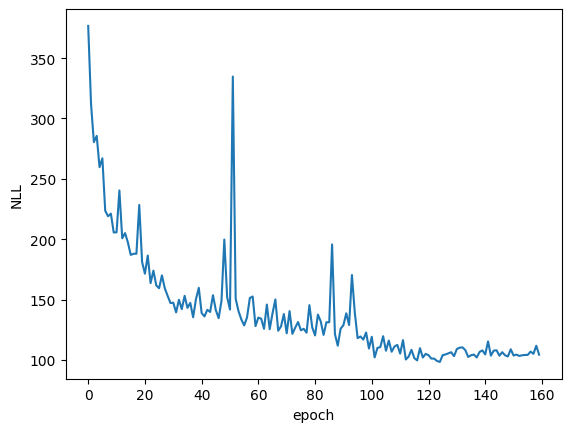

Training epoch 160


100%|██████████| 75/75 [00:18<00:00,  4.01batch/s, loss=109] 


- Log loss: 107.54492950439453
[3.125e-06]
Training epoch 161


100%|██████████| 75/75 [00:18<00:00,  4.03batch/s, loss=39.2]


- Log loss: 103.9000473022461
[3.125e-06]
Training epoch 162


100%|██████████| 75/75 [00:18<00:00,  4.00batch/s, loss=38.2]


- Log loss: 106.91600036621094
[3.125e-06]
Training epoch 163


 84%|████████▍ | 63/75 [00:15<00:03,  3.98batch/s, loss=61.7]


KeyboardInterrupt: 

In [35]:
# from models import *
# from trainer import *
# from loader import *
from torch.distributions.bernoulli import Bernoulli
from torch.distributions.multivariate_normal import MultivariateNormal
import sys

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn import DataParallel

#python3 train.py 12 FINAL_12/

# Input arguments
# channels = int(sys.argv[1])
# out_dir = sys.argv[2]

channels = 12
out_dir = '/kaggle/working/train_out/'

# Set up 
torch.manual_seed(0)
torch.backends.cudnn.benchmark = True
device = torch.device('cuda')

# Set up model
model = UNet_Attention(img_ch=channels,
            output_ch=1,
            )
# model = Unet(in_channels=channels,
#             out_channels=1,
#             div_factor=1, 
#             prob_output=False)
model = model.to(device)
model = nn.DataParallel(model)

# Set up loss function
loss_fn = FocalLoss(alpha=0.75, gamma=2.0)

train_dataset = MethaneLoader(device = "cuda", mode="train", plume_id=None, channels=channels)
test_dataset = MethaneLoader(device = "cuda", mode="test", plume_id=None, channels=channels)

#print(train_dataset.__len__())

train_loader = DataLoader(train_dataset, 
                          batch_size = 16, 
                          shuffle = True)

test_loader = DataLoader(test_dataset, 
                          batch_size = 16, 
                          shuffle = True)


# Make the trainer
trainer = Trainer(model,
                  train_loader,
                  test_loader,
                  train_dataset,
                  loss_fn,
                  out_dir,
                  1e-4)

# Train
trainer.train(n_epochs=200)

In [ ]:
### for clearing directory
### skip it
#!rm -rf /kaggle/working/*

In [36]:
def visualize(idx):
    file_paths = glob('/kaggle/input/ch4net-dataset/data/val/mbmp/*/{}.npy'.format(idx))
    for file in file_paths:
        category = file.split("/")[-2]
        print(category)
        image1 = np.load(file)
    image2 = np.load("/kaggle/working/eval_out/target_{}.npy".format(idx))
    image3 = np.load("/kaggle/working/eval_out/out_{}.npy".format(idx))

    # Squeeze the extra dimension if needed
    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)
    image3 = np.squeeze(image3)

    print(image1.shape, image2.shape, image3.shape)

    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display each image
    axes[0].imshow(image1, cmap='magma')
    axes[0].set_title('MBMP')
    axes[0].axis('off')  # Hide axis

    axes[1].imshow(image2, cmap='magma')
    axes[1].set_title('Target')
    axes[1].axis('off')  # Hide axis

    axes[2].imshow(image3, cmap='magma')
    axes[2].set_title('Out')
    axes[2].axis('off')  # Hide axis

    # Show the figure
    plt.tight_layout()
    plt.show()

In [37]:
from matplotlib import pyplot as plt
import torch
import numpy as np
from tqdm import tqdm

# from models import *
# from trainer import *
# from loader import *

from torch.utils.data import DataLoader
from glob import glob

# python3 gen_eval_preds.py 12 final_12_all/ final_12_preds/ 0
# in_dir = sys.argv[2]
# out_dir = sys.argv[3]
# channels = int(sys.argv[1])
# alli_yn = bool(int(sys.argv[4]))

in_dir = "/kaggle/working/train_out/"
out_dir = "/kaggle/working/eval_out/"
channels = 12
alli_yn = False

print("Loading losses...")
losses = np.load(in_dir+"losses.npy")
best_epoch = np.argmin(losses)
print('best epoch: ', best_epoch)

device = torch.device('cuda')

# Set up model
model = UNet_Attention(img_ch=channels,
            output_ch=1,
            )
# model = Unet(in_channels=channels,
#             out_channels=1,
#             div_factor=1, 
#             prob_output=False)
model = model.to(device)
model = nn.DataParallel(model)

model.load_state_dict(torch.load(in_dir+"final_model",
                      map_location=torch.device('cuda'))["model_state_dict"])
# model.load_state_dict(torch.load('/kaggle/input/ch4net_attention/pytorch/default/1/final_model',
#                       map_location=torch.device('cuda'))["model_state_dict"])
model.eval()
print()

Loading losses...
best epoch:  124


/tmp/ipykernel_36/4057273278.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(in_dir+"final_model",


In [38]:
import torch
import numpy as np

def calculate_iou(pred, target):
    """
    Calculate Intersection over Union (IoU)
    """
    pred = pred > 0  # Convert to binary mask
    target = target > 0  # Convert to binary mask
    intersection = np.logical_and(target, pred)
    union = np.logical_or(target, pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_accuracy(pred, target):
    """
    Calculate pixel-wise accuracy
    """
    pred = pred > 0  # Convert to binary mask
    target = target > 0  # Convert to binary mask
    correct = np.sum(pred == target)
    total = pred.size
    return correct / total

In [39]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import balanced_accuracy_score

def calculate_metrics(pred, target, epsilon=1e-6):
    """
    Calculate IoU, Accuracy, Recall, Balanced Accuracy, False Positive Rate, and False Negative Rate
    """
    pred = F.sigmoid(torch.tensor(pred)).numpy()
    pred = pred > 0.5 # Convert to binary mask
    target = target > 0  # Convert to binary mask
    
    true_positive = np.sum(np.logical_and(pred, target))
    false_positive = np.sum(np.logical_and(pred, np.logical_not(target)))
    false_negative = np.sum(np.logical_and(np.logical_not(pred), target))
    true_negative = np.sum(np.logical_and(np.logical_not(pred), np.logical_not(target)))
    
    # IoU
    union = np.sum(np.logical_or(pred, target))
    iou = (true_positive + epsilon) / (union + epsilon)
    
    # Accuracy
    total = pred.size
    accuracy = (true_positive + true_negative) / total
    
    # Recall (True Positive Rate)
    recall = (true_positive + epsilon) / (true_positive + false_negative + epsilon)
    
    # False Positive Rate
    fpr = (false_positive + epsilon) / (false_positive + true_negative + epsilon)
    
    # False Negative Rate
    fnr = (false_negative + epsilon) / (false_negative + true_positive + epsilon)
    
    # Balanced Accuracy
#     balanced_acc = balanced_accuracy_score(target.flatten(), pred.flatten())
    balanced_acc = None
    
    return iou, accuracy, recall, balanced_acc, fpr, fnr

# ... [Previous imports and setup code remains the same]

losses = []
ious = []
accuracies = []
recalls = []
balanced_accs = []
fprs = []
fnrs = []

# Iterate over each plume
for i in tqdm(range(250)):
    preds = []
    targets = []

    test_dataset = MethaneLoader(
        device="cuda", mode="val", alli=alli_yn, plume_id=i, channels=channels)

    val_loader = DataLoader(test_dataset,
                            batch_size=64,
                            shuffle=False)

    for batch in val_loader:
        out = model(batch["pred"])
        preds.append(np.squeeze(out).cpu())
        targets.append(np.squeeze(batch["target"]).cpu())
        loss_val = loss_fn(np.squeeze(out), np.squeeze(batch["target"]))
        losses.append(loss_val.item())
        
    if len(preds) > 0:
        preds = torch.concat(preds, dim=0).detach().numpy()
        targets = torch.concat(targets, dim=0).detach().numpy()

        # Calculate metrics for this plume
        iou, accuracy, recall, balanced_acc, fpr, fnr = calculate_metrics(preds, targets)
        
        ious.append(iou)
        accuracies.append(accuracy)
        recalls.append(recall)
        balanced_accs.append(balanced_acc)
        fprs.append(fpr)
        fnrs.append(fnr)
        
        preds = F.sigmoid(torch.tensor(preds)).numpy()
        preds = preds > 0.5 # Convert to binary mask
        np.save(out_dir+f"out_{i}.npy", preds)
        np.save(out_dir+f"target_{i}.npy", targets)

# Calculate and print overall metrics
mean_loss = np.mean(losses)
mean_iou = np.mean(ious)
mean_accuracy = np.mean(accuracies)
mean_recall = np.mean(recalls)
# mean_balanced_acc = np.mean(balanced_accs)
mean_fpr = np.mean(fprs)
mean_fnr = np.mean(fnrs)

print(f"Mean Loss: {mean_loss:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
# print(f"Mean Balanced Accuracy: {mean_balanced_acc:.4f}")
print(f"Mean False Positive Rate: {mean_fpr:.4f}")
print(f"Mean False Negative Rate: {mean_fnr:.4f}")

# Save metrics
np.save(out_dir+"metrics.npy", {
    "loss": mean_loss,
    "iou": mean_iou,
    "accuracy": mean_accuracy,
    "recall": mean_recall,
#     "balanced_accuracy": mean_balanced_acc,
    "false_positive_rate": mean_fpr,
    "false_negative_rate": mean_fnr
})

100%|██████████| 250/250 [00:17<00:00, 14.28it/s]

Mean Loss: 167.2141
Mean IoU: 0.5978
Mean Accuracy: 0.9835
Mean Recall: 0.7448
Mean False Positive Rate: 0.0073
Mean False Negative Rate: 0.7693


neg
100.0


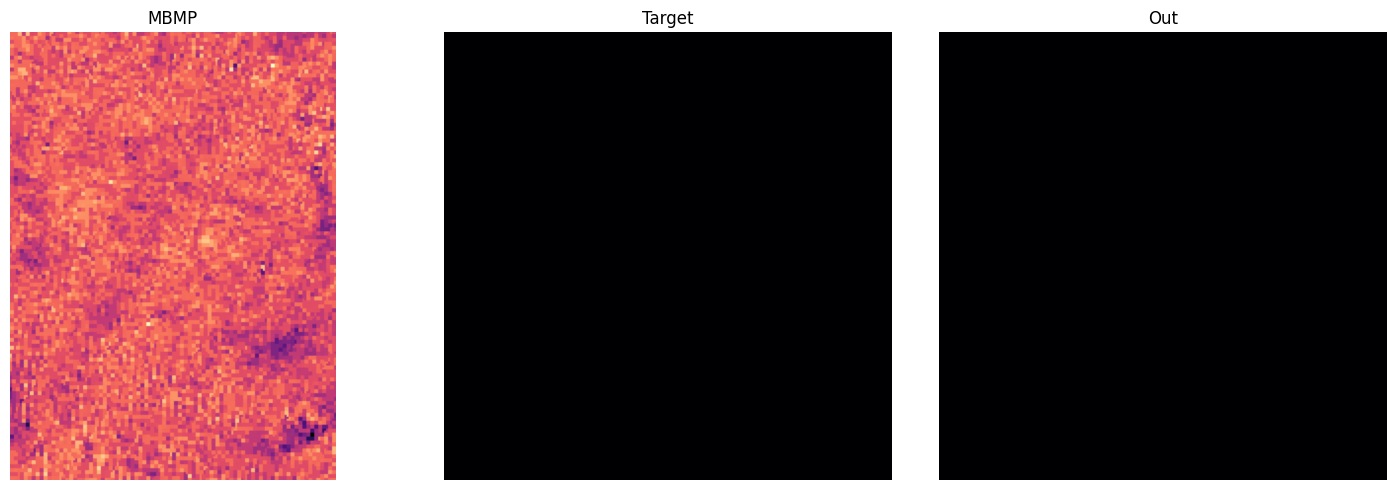

neg
100.0


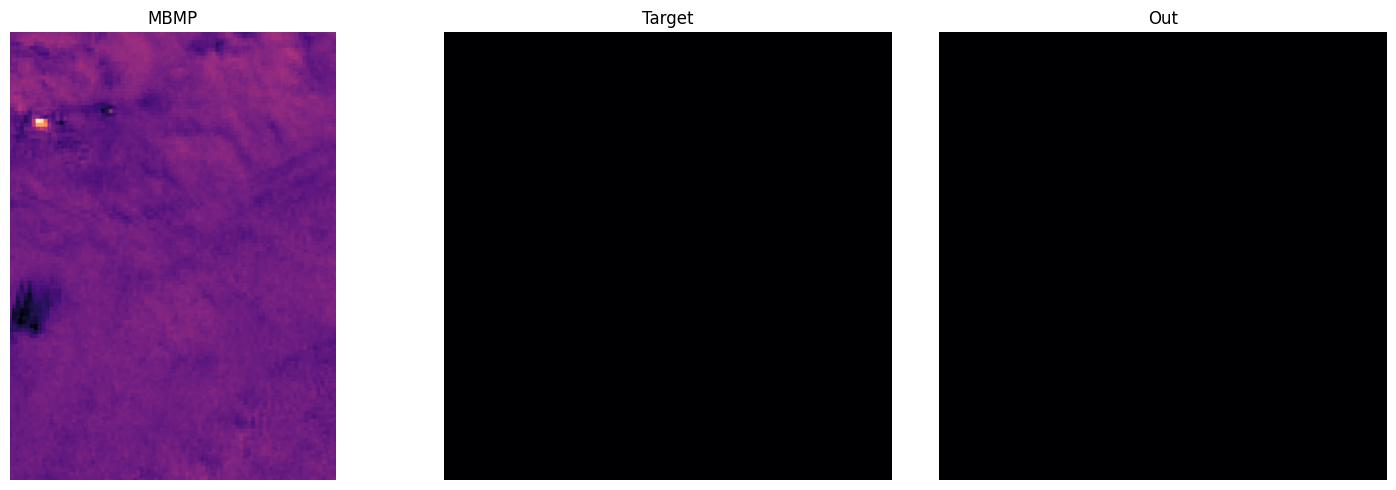

neg
100.0


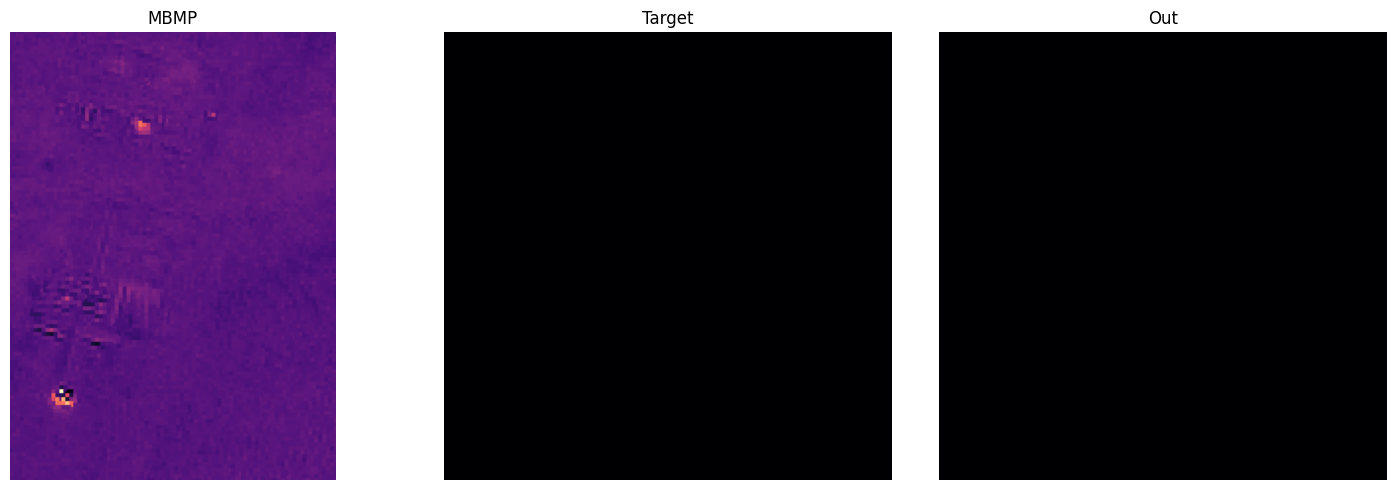

pos
2.7624309315954944e-07


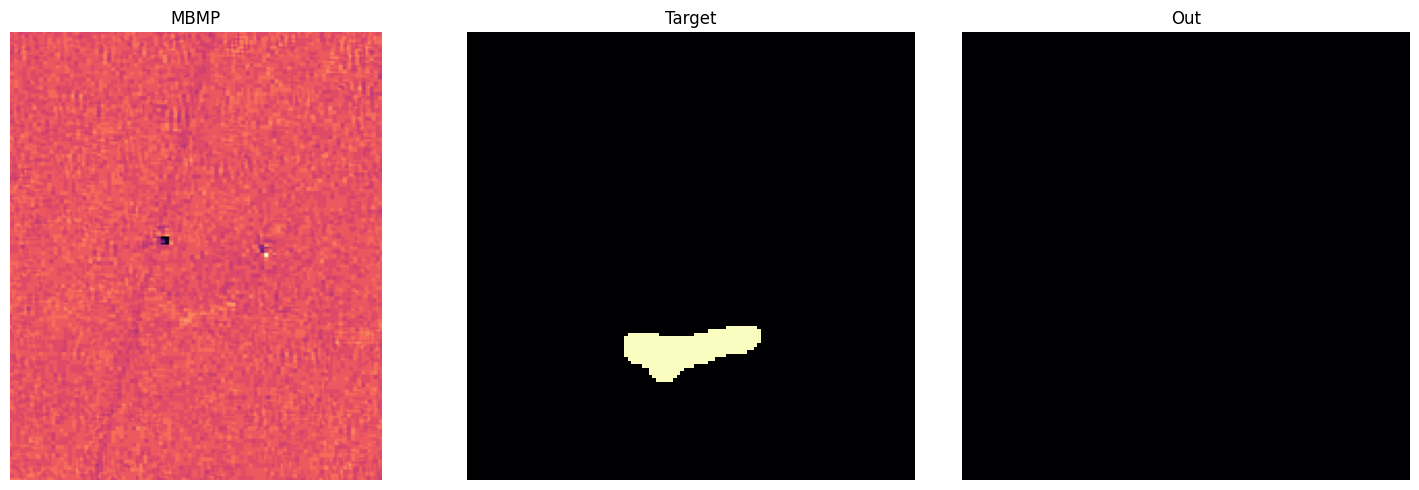

pos
59.75359351179961


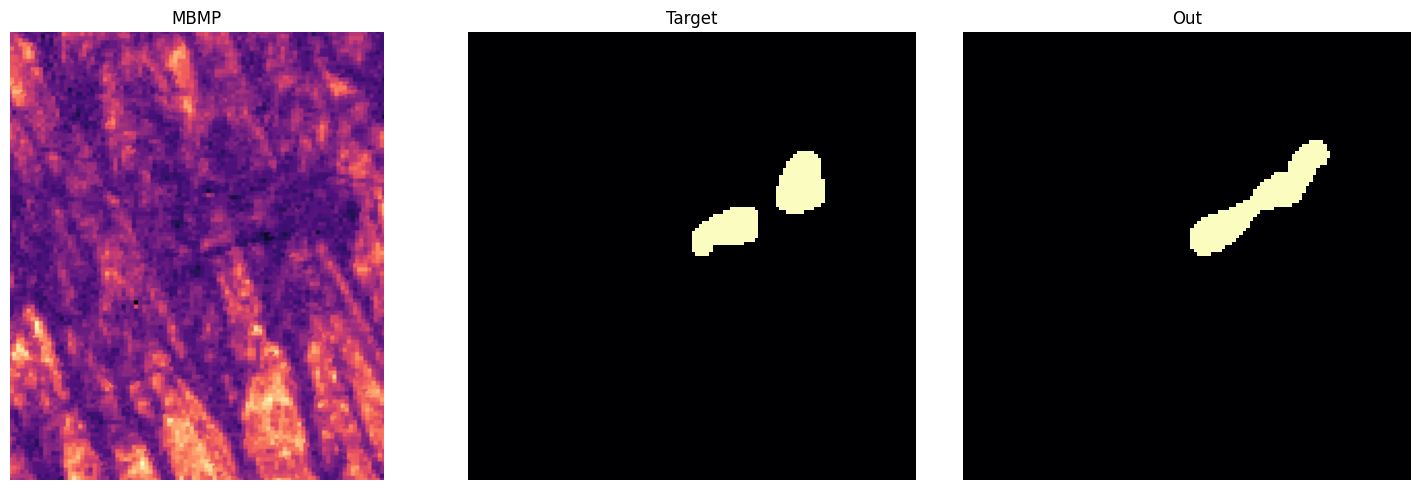

neg
100.0


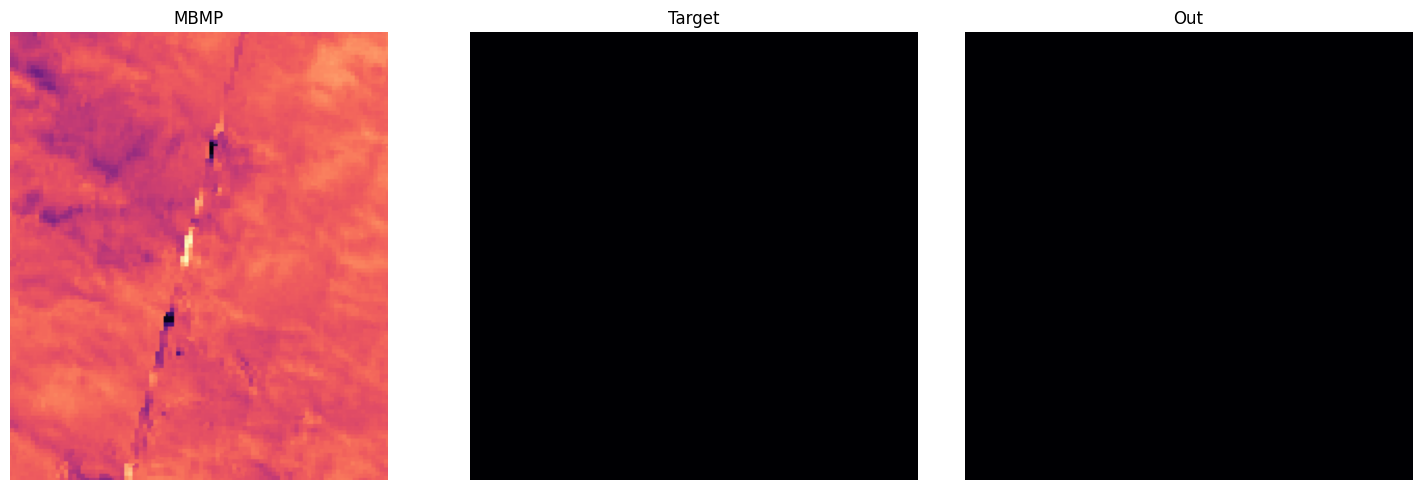

neg
1.2499998437500197e-05


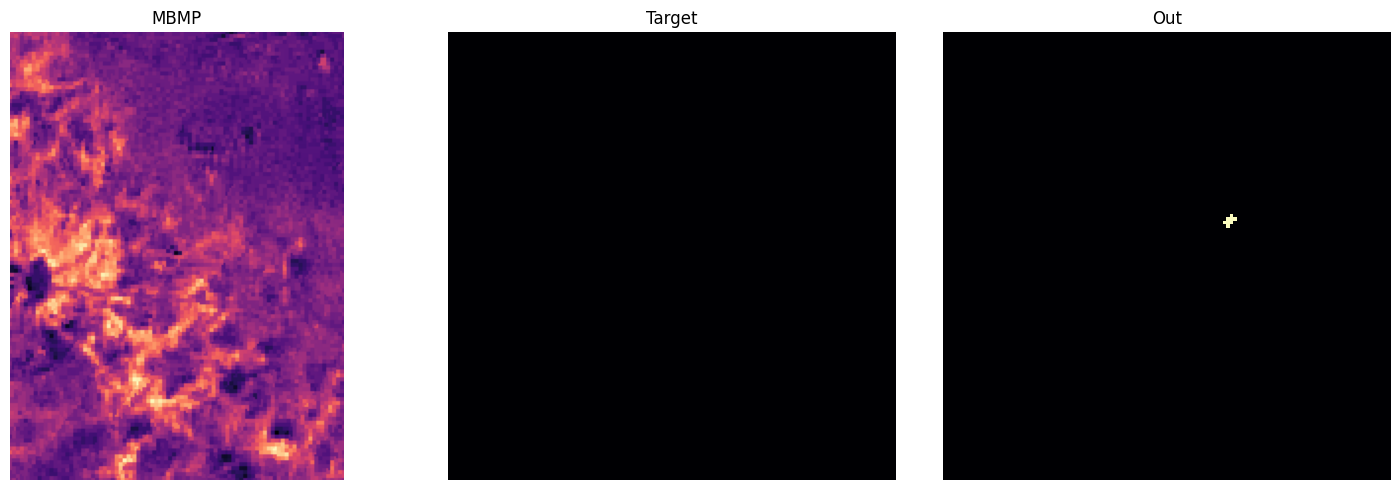

pos
2.890173402051522e-07


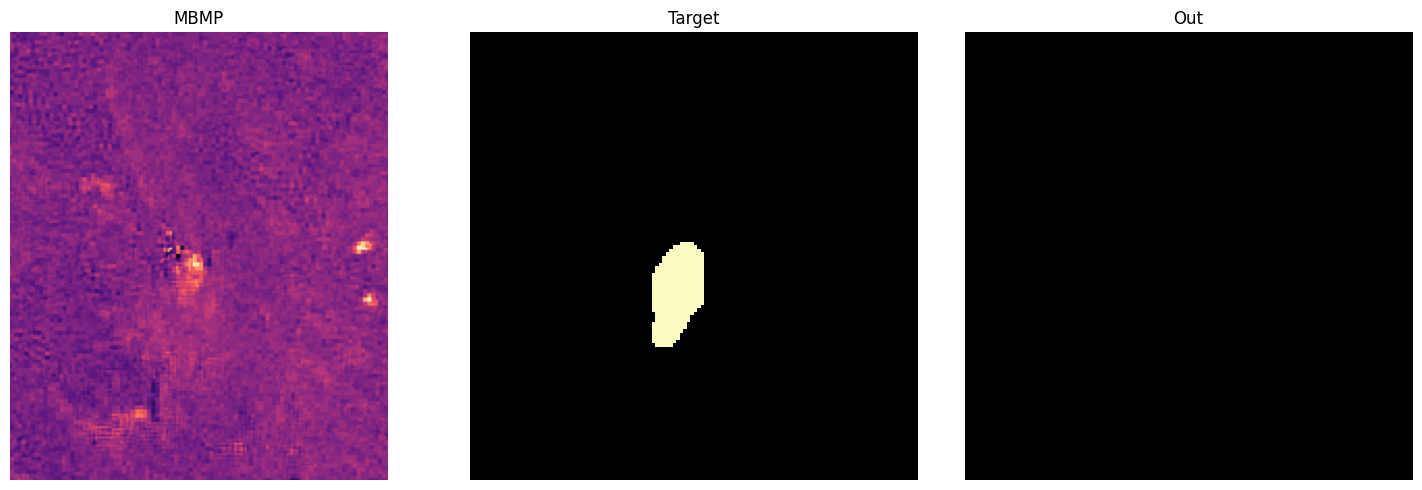

neg
100.0


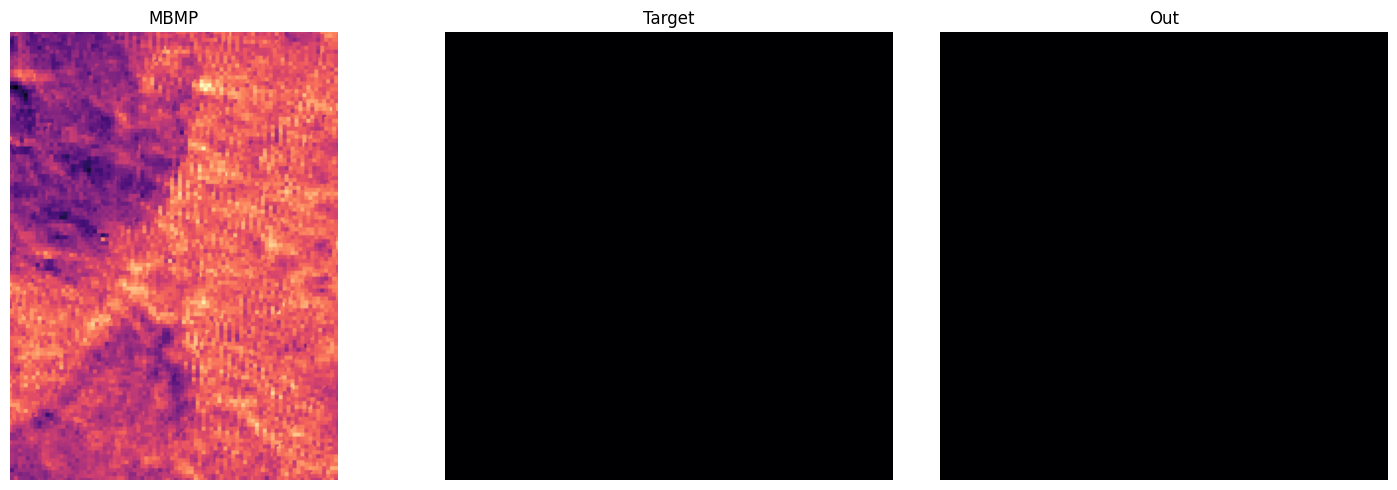

pos
29.190751649737713


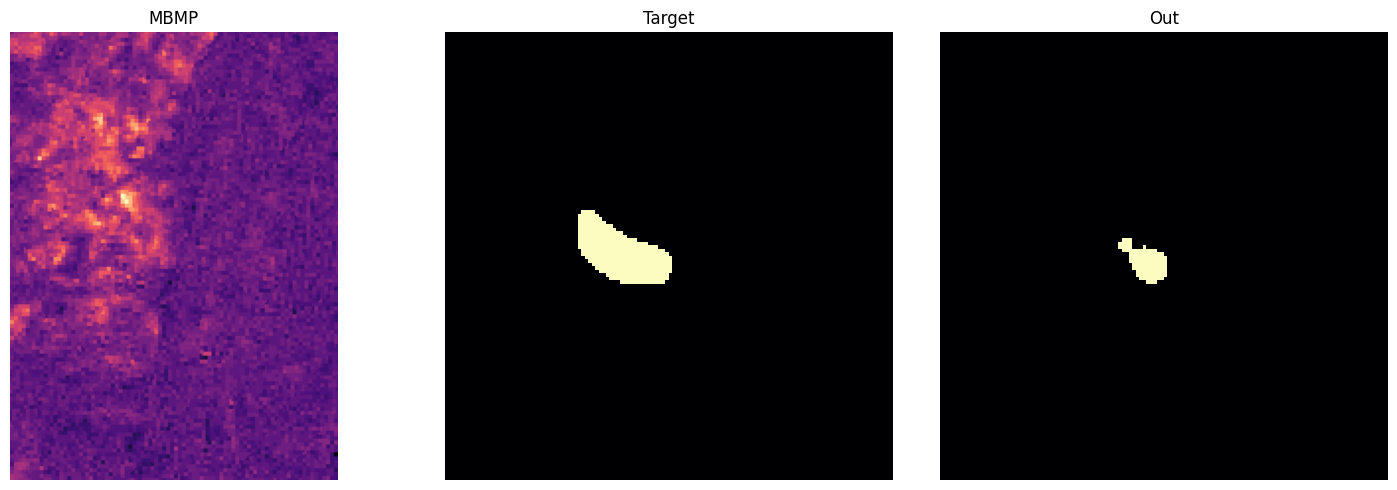

In [40]:
# from glob import glob

# visualize masks
samples = 250

# def visualize(idx):
    
for i in range(samples):
    idx = np.random.randint(0, samples)
#     idx = i

    file_paths = glob('/kaggle/input/ch4net-dataset/data/val/mbmp/*/{}.npy'.format(idx))
    for file in file_paths:
        category = file.split("/")[-2]
        print(category)
        image1 = np.load(file)
    image2 = np.load("/kaggle/working/eval_out/target_{}.npy".format(idx))
    image3 = np.load("/kaggle/working/eval_out/out_{}.npy".format(idx))

    # Squeeze the extra dimension if needed
    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)
    image3 = np.squeeze(image3)
#     print(image2.shape)
    
    eps = 1e-6
    pred = image3
    target = image2
    iou = (np.sum(np.logical_and(pred, target)) + eps) / (np.sum(np.logical_or(pred, target)) + eps) * 100
    
    print(iou)

#     print(image1.shape, image2.shape, image3.shape)
#     print(losses[idx])

    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display each image
    axes[0].imshow(image1, cmap='magma')
    axes[0].set_title('MBMP')
    axes[0].axis('off')  # Hide axis

    axes[1].imshow(image2, cmap='magma')
    axes[1].set_title('Target')
    axes[1].axis('off')  # Hide axis

    axes[2].imshow(image3, cmap='magma')
    axes[2].set_title('Out')
    axes[2].axis('off')  # Hide axis

    # Show the figure
    plt.tight_layout()
    plt.show()
    
    i = i + 1
    if(i==10): break
